# RVL-CDIP Dataset Overview


**Dataset Details:**
- 400,000 grayscale images of scanned documents
- 16 document categories
- Image resolution: varies (typically ~1000x1000 pixels)
- Format: Parquet (via `chainyo/rvl-cdip` on Hugging Face Hub)

## 1. Setup and Imports

In [2]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from traenslenzor.doc_classifier.data_handling.huggingface_rvl_cdip_ds import (
    RVLCDIPConfig,
    make_transform_fn,
)
from traenslenzor.doc_classifier.utils import Stage

## 2. Loading the Dataset

Load a small subset for exploration (first 100 examples from train split).

In [3]:
# Load train split configuration
config = RVLCDIPConfig(split=Stage.TRAIN, verbose=True)
config.inspect()

RVLCDIPConfig
├── target: NoTarget (Callable[BaseConfig, TargetType])
├── propagated_fields: {} (dict[str, Any])
├── hf_hub_name: "chainyo/rvl-cdip" (<class 'str'>)
├── split: ('train', 'fit') (<enum 'Stage'>)
├── streaming: False (<class 'bool'>)
├── num_workers: 4 (<class 'int'>)
├── is_debug: False (<class 'bool'>)
└── verbose: True (<class 'bool'>)

In [4]:
# Load the dataset
dataset = config.setup_target()
print(f"\nDataset loaded: {dataset}")

[RVLCDIPConfig::setup_target]: Synchronizing RVL-CDIP split='train' with local cache.

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/319999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/64 [00:00<?, ?it/s]


Dataset loaded: Dataset({
    features: ['image', 'label'],
    num_rows: 319999
})


## 3. Dataset Properties

### 3.1 Dataset Features

In [5]:
# Access dataset features
print("Dataset Features:")
print(f"  {dataset.features}")
print()

# Image feature details
image_feature = dataset.features["image"]
print(f"Image Feature Type: {type(image_feature).__name__}")
print(f"  - Decode: {image_feature.decode}")
print(f"  - Mode: {image_feature.mode}")
print()

# Label feature details
label_feature = dataset.features["label"]
print(f"Label Feature Type: {type(label_feature).__name__}")
print(f"  - Number of classes: {label_feature.num_classes}")

Dataset Features:
  {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['advertisement', 'budget', 'email', 'file folder', 'form', 'handwritten', 'invoice', 'letter', 'memo', 'news article', 'presentation', 'questionnaire', 'resume', 'scientific publication', 'scientific report', 'specification'])}

Image Feature Type: Image
  - Decode: True
  - Mode: None

Label Feature Type: ClassLabel
  - Number of classes: 16


### 3.2 Number of Classes

In [6]:
# Get number of classes
num_classes = dataset.features["label"].num_classes
print(f"Total number of document classes: {num_classes}")

Total number of document classes: 16


### 3.3 Class Names and Label Mapping

In [7]:
# Get class names
class_names = dataset.features["label"].names

print("Document Classes (Label → Name):")
print("=" * 50)
for idx, name in enumerate(class_names):
    print(f"  {idx:2d}: {name}")

Document Classes (Label → Name):
   0: advertisement
   1: budget
   2: email
   3: file folder
   4: form
   5: handwritten
   6: invoice
   7: letter
   8: memo
   9: news article
  10: presentation
  11: questionnaire
  12: resume
  13: scientific publication
  14: scientific report
  15: specification


In [8]:
# Create bidirectional mapping helpers
label_to_name = {idx: name for idx, name in enumerate(class_names)}
name_to_label = {name: idx for idx, name in enumerate(class_names)}

# Example usage
print("\nExample Mappings:")
print(f"  Label 0 → '{label_to_name[0]}'")
print(f"  Label 5 → '{label_to_name[5]}'")
print(f"  'invoice' → Label {name_to_label['invoice']}")
print(f"  'letter' → Label {name_to_label['letter']}")


Example Mappings:
  Label 0 → 'advertisement'
  Label 5 → 'handwritten'
  'invoice' → Label 6
  'letter' → Label 7


### 3.4 Dataset Splits and Sizes

**Note:** This dataset uses non-standard split names: `'train'`, `'val'`, `'test'` (not `'validation'`)

In [9]:
# Load all splits to show sizes
train_ds = RVLCDIPConfig(split=Stage.TRAIN, verbose=False).setup_target()
val_ds = RVLCDIPConfig(split=Stage.VAL, verbose=False).setup_target()
test_ds = RVLCDIPConfig(split=Stage.TEST, verbose=False).setup_target()

print("Dataset Split Sizes:")
print("=" * 50)
print(f"  Train:      {len(train_ds):,} examples")
print(f"  Validation: {len(val_ds):,} examples")
print(f"  Test:       {len(test_ds):,} examples")
print(f"  Total:      {len(train_ds) + len(val_ds) + len(test_ds):,} examples")

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/64 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Dataset Split Sizes:
  Train:      319,999 examples
  Validation: 40,000 examples
  Test:       40,000 examples
  Total:      399,999 examples


## 4. Exploring Sample Data

### 4.1 Single Example Structure

In [10]:
# Get first example
example = dataset[0]

print("Example Structure:")
print(f"  Keys: {list(example.keys())}")
print()
print(f"  Image type: {type(example['image'])}")
print(f"  Image size: {example['image'].size}")
print(f"  Image mode: {example['image'].mode}")
print()
print(f"  Label: {example['label']} ({label_to_name[example['label']]})")

Example Structure:
  Keys: ['image', 'label']

  Image type: <class 'PIL.Image.Image'>
  Image size: (781, 1000)
  Image mode: L

  Label: 0 (advertisement)


### 4.2 Image Size Distribution

In [11]:
# Sample 100 images to analyze sizes
sample_indices = range(0, min(1000, len(dataset)), 10)  # Every 10th image from first 1000
image_sizes = [dataset[i]["image"].size for i in sample_indices]

widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

print(f"Image Size Statistics (sample of {len(image_sizes)} images):")
print("=" * 50)
print(f"  Width:  min={min(widths):4d}, max={max(widths):4d}, avg={int(np.mean(widths)):4d}")
print(f"  Height: min={min(heights):4d}, max={max(heights):4d}, avg={int(np.mean(heights)):4d}")

Image Size Statistics (sample of 100 images):
  Width:  min= 596, max= 968, avg= 770
  Height: min=1000, max=1000, avg=1000


### 4.3 Class Distribution

In [12]:
# Analyze class distribution in first 1000 examples
sample_size = 1000
labels = [dataset[i]["label"] for i in range(min(sample_size, len(dataset)))]
label_counts = Counter(labels)

print(f"Class Distribution (first {sample_size} examples):")
print("=" * 60)
for label_idx in sorted(label_counts.keys()):
    count = label_counts[label_idx]
    pct = (count / sample_size) * 100
    name = label_to_name[label_idx]
    print(f"  {label_idx:2d} {name:25s}: {count:4d} ({pct:5.1f}%)")

Class Distribution (first 1000 examples):
   0 advertisement            : 1000 (100.0%)


## 5. Visualizing Sample Images

Display one example from each document class.

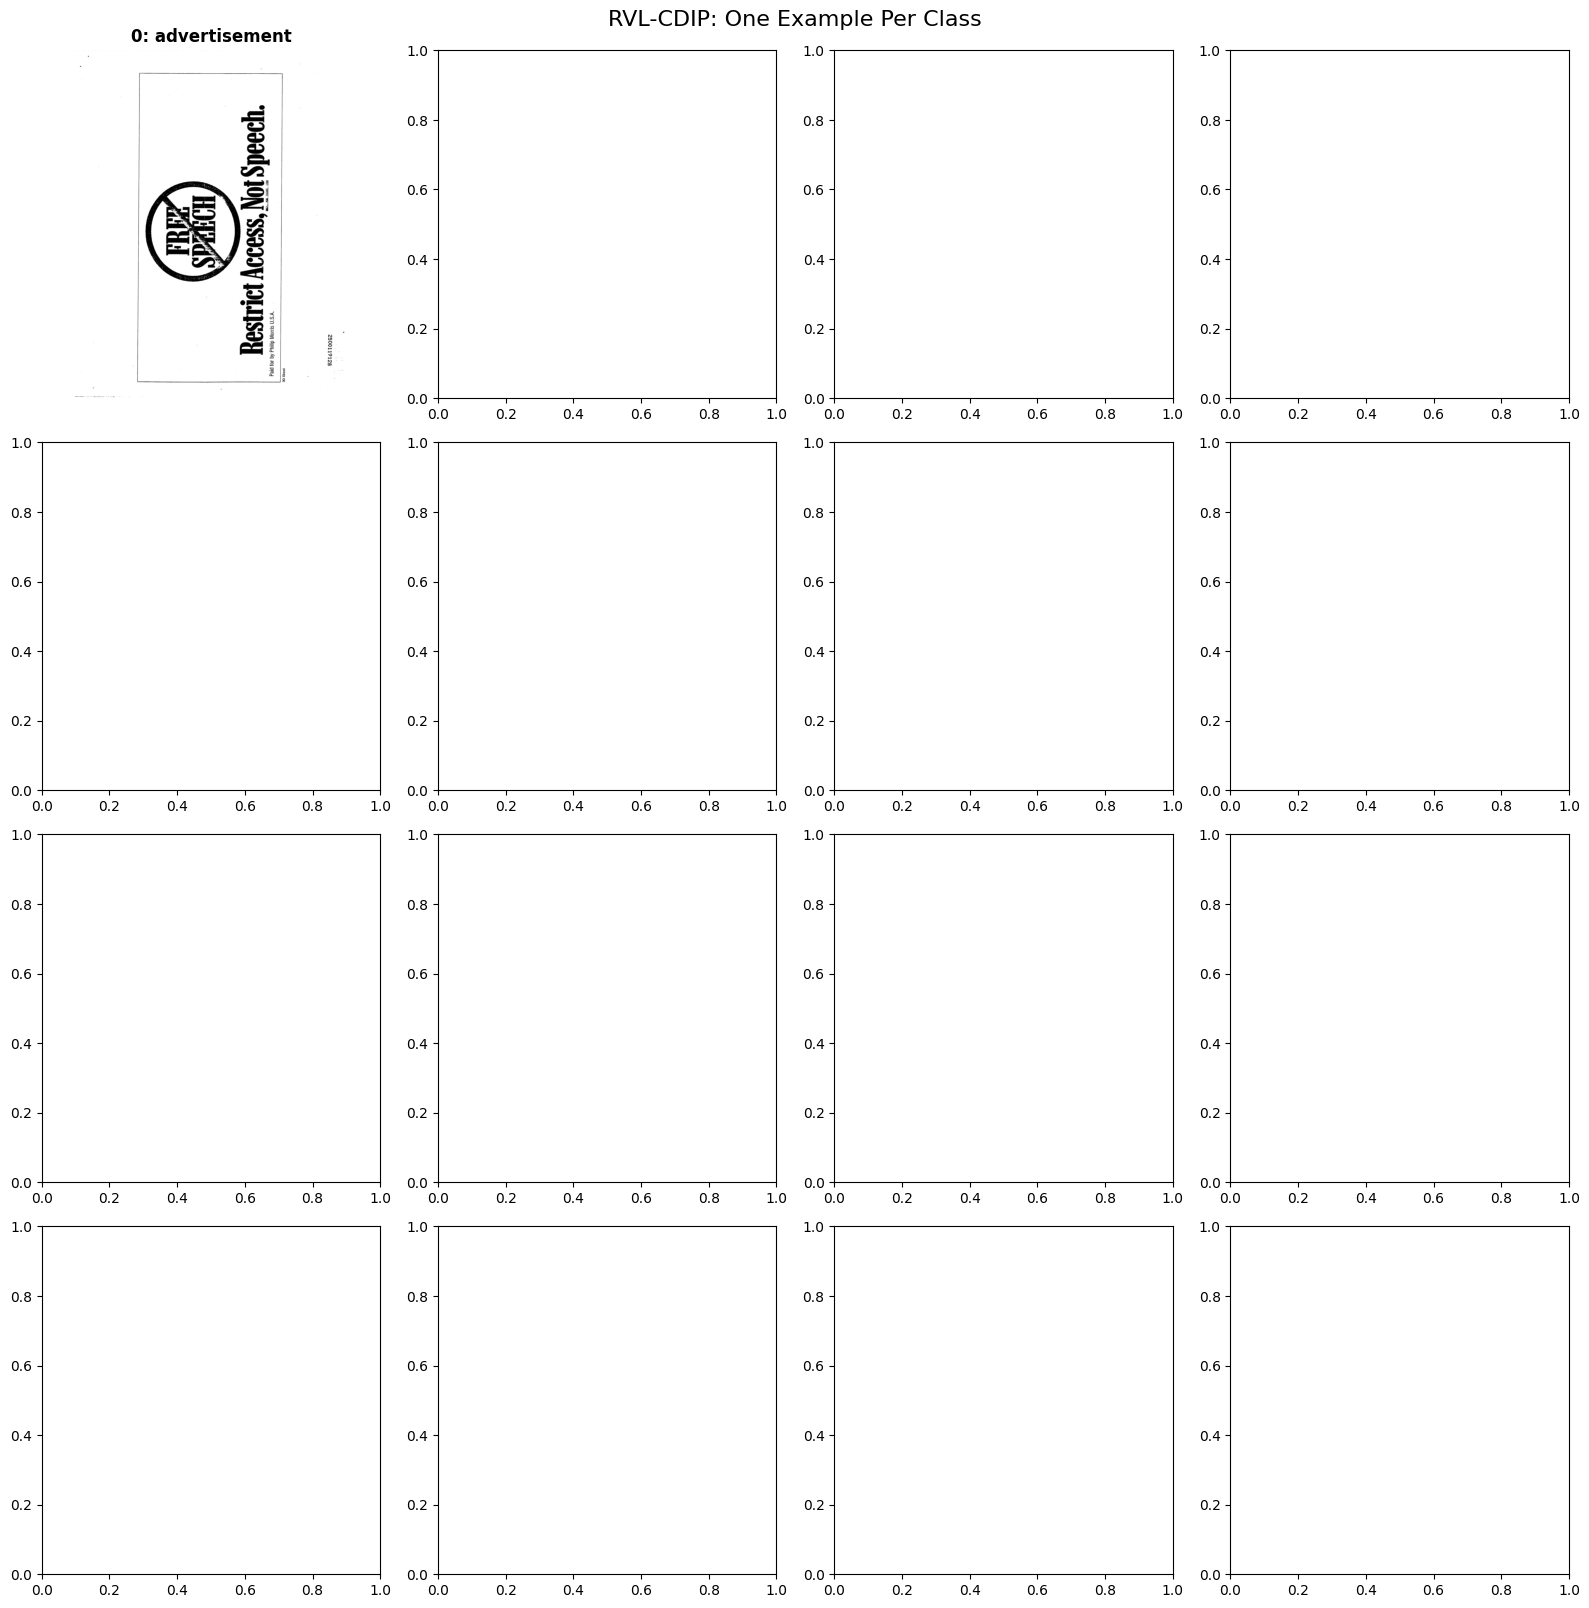

In [13]:
# Find one example of each class
class_examples = {}
for i in range(min(5000, len(dataset))):  # Search first 5000 examples
    label = dataset[i]["label"]
    if label not in class_examples:
        class_examples[label] = dataset[i]
    if len(class_examples) == num_classes:
        break

# Plot examples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for idx, (label, example) in enumerate(sorted(class_examples.items())):
    ax = axes[idx]
    ax.imshow(example["image"], cmap="gray")
    ax.set_title(f"{label}: {label_to_name[label]}", fontsize=12, fontweight="bold")
    ax.axis("off")

plt.tight_layout()
plt.suptitle("RVL-CDIP: One Example Per Class", fontsize=16, y=1.002)
plt.show()

## 6. Using with Transforms

### 6.1 Apply Albumentations Transforms

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define transform pipeline
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=[0.485], std=[0.229]),  # Grayscale normalization
        ToTensorV2(),
    ]
)

# Create transform function
transform_fn = make_transform_fn(transform)

# Apply to dataset
dataset.set_transform(transform_fn)

print("Transform applied!")
print("\nTransformed example:")
transformed = dataset[0]
print(f"  Image shape: {transformed['image'].shape}")
print(f"  Image dtype: {transformed['image'].dtype}")
print(f"  Label: {transformed['label']}")

Transform applied!

Transformed example:
  Image shape: torch.Size([1, 224, 224])
  Image dtype: torch.float32
  Label: 0


### 6.2 Visualize Transformed vs Original

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/64 [00:00<?, ?it/s]

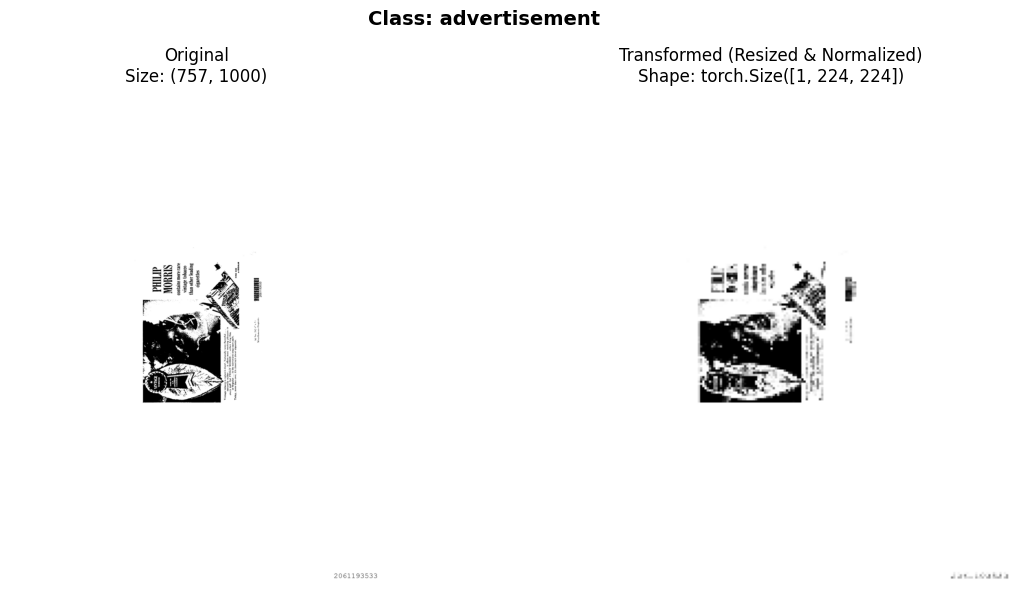

In [15]:
# Reload dataset without transforms for comparison
original_ds = RVLCDIPConfig(split=Stage.TRAIN, verbose=False).setup_target()

# Get same example
idx = 42
original = original_ds[idx]
transformed = dataset[idx]

# Convert tensor back to numpy for visualization
transformed_img = transformed["image"].squeeze().numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
axes[0].imshow(original["image"], cmap="gray")
axes[0].set_title(f"Original\nSize: {original['image'].size}", fontsize=12)
axes[0].axis("off")

# Transformed
axes[1].imshow(transformed_img, cmap="gray")
axes[1].set_title(
    f"Transformed (Resized & Normalized)\nShape: {transformed['image'].shape}", fontsize=12
)
axes[1].axis("off")

plt.suptitle(f"Class: {label_to_name[original['label']]}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 7. Integration with PyTorch DataLoader

In [16]:
from torch.utils.data import DataLoader

# Create DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

# Get one batch
batch = next(iter(dataloader))

print("Batch structure:")
print(f"  Images: {batch['image'].shape} ({batch['image'].dtype})")
print(f"  Labels: {batch['label'].shape} ({batch['label'].dtype})")
print()
print("Label distribution in batch:")
batch_labels = batch["label"].numpy()
for label_idx, count in sorted(Counter(batch_labels).items()):
    print(f"  {label_to_name[label_idx]:25s}: {count}")

Batch structure:
  Images: torch.Size([16, 1, 224, 224]) (torch.float32)
  Labels: torch.Size([16]) (torch.int64)

Label distribution in batch:
  budget                   : 2
  file folder              : 3
  handwritten              : 1
  letter                   : 1
  news article             : 2
  questionnaire            : 3
  resume                   : 2
  scientific report        : 1
  specification            : 1


## 8. Summary: Quick Reference

```python
# Load dataset
from traenslenzor.doc_classifier.data_handling.huggingface_rvl_cdip_ds import RVLCDIPConfig
from traenslenzor.doc_classifier.utils import Stage

config = RVLCDIPConfig(split=Stage.TRAIN)
dataset = config.setup_target()

# Number of classes
num_classes = dataset.features['label'].num_classes  # 16

# Class names
class_names = dataset.features['label'].names
# ['advertisement', 'budget', 'email', 'file folder', 'form', 
#  'handwritten', 'invoice', 'letter', 'memo', 'news article',
#  'presentation', 'questionnaire', 'resume', 'scientific publication',
#  'scientific report', 'specification']

# Label ↔ Name mapping
label_to_name = {i: name for i, name in enumerate(class_names)}
name_to_label = {name: i for i, name in enumerate(class_names)}

# Dataset features
dataset.features  # {'image': Image(...), 'label': ClassLabel(...)}

# Split sizes
# Train: 320,000 | Validation: 40,000 | Test: 40,000
```